In [1]:
import os

os.getcwd()
os.chdir("../../")
os.getcwd()

'/data01/dl23vitcas/dl_project'

In [2]:
import sys
import argparse
import os

sys.argv = ["view", "--config", "config/single_task_object_detection.yaml"]

parser = argparse.ArgumentParser()
parser.add_argument("--config", type=str, required=True, help="Path to the config file")
args = parser.parse_args()

print(args.config)

config/single_task_object_detection.yaml


In [3]:
from dataloader import VOC08Attr
from torchvision.transforms import transforms
from config_experiments import config
import torch
from torch.utils.data import DataLoader

import numpy as np

In [4]:
transform_train = transforms.Compose(
    [
        transforms.Resize(size=600, max_size=1000),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=config["transform"]["mean"], std=config["transform"]["std"]
        ),
    ]
)

In [5]:
train_data = VOC08Attr(train=True, transform=transform_train)
train_dataloader = DataLoader(
    train_data,
    batch_size=config["preprocessing"]["n_images"],
    collate_fn=train_data.collate_fn,
    shuffle=False,
)

In [6]:
import torch
import torchvision.transforms.functional as F
from torchvision.utils import draw_bounding_boxes
import matplotlib.pyplot as plt
import numpy as np


def show(imgs):
    plt.rcParams["savefig.bbox"] = "tight"
    if not isinstance(imgs, list):
        imgs = [imgs]
    fix, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)  # (H, W)
        axs[0, i].imshow(np.asarray(img))  # (W, H, 3)
        # axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[]) # uncomment to remove axis in plot


def show_bbox_with_transform(image, box, mean, std, labels=None, color="white"):
    image = np.array(image)
    for channel in range(3):
        image[channel] = image[channel] * std[channel] + mean[channel]
    image = np.clip(image, 0, 1)
    image = (image * 255).astype(np.uint8)
    image = torch.from_numpy(image)
    show(draw_bounding_boxes(image, box, colors=color, labels=labels, width=2))

tensor([[  0.,  55., 678., 600.],
        [290.,  71., 454., 223.],
        [274.,  53., 542., 239.],
        [292.,  59., 533., 182.],
        [  0., 206., 678., 600.],
        [  0.,  53., 678., 600.],
        [290.,  80., 403., 223.],
        [  0.,   0., 678., 600.],
        [  0., 129., 545., 600.],
        [290.,  53., 542., 223.],
        [264.,  76., 454., 250.],
        [247.,  76., 454., 250.],
        [  0.,  59., 678., 600.],
        [136.,   0., 678., 600.],
        [  0., 270., 197., 600.],
        [  0.,   0., 392., 141.],
        [  0.,  53., 587., 297.],
        [136.,  15., 462., 248.],
        [136.,  15., 464., 248.],
        [ 89., 206., 278., 585.],
        [426., 198., 593., 379.],
        [297., 356., 572., 487.],
        [297., 272., 670., 600.],
        [221.,  87., 407., 250.],
        [175., 263., 678., 600.],
        [354., 129., 511., 376.],
        [453., 117., 606., 343.],
        [123., 206., 199., 600.],
        [  0.,   0., 439., 217.],
        [403.,

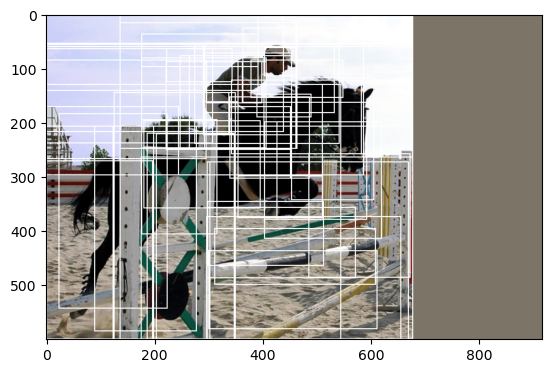

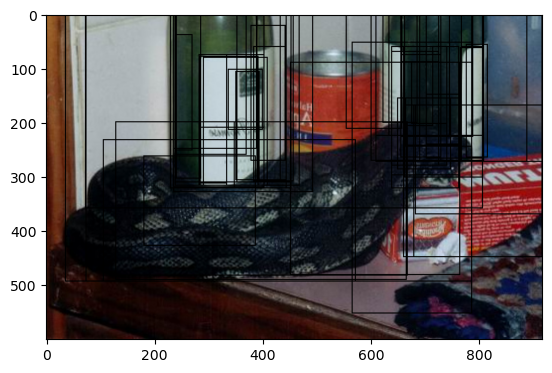

In [7]:
for i, (batch_images, rois, classes, offsets, attrs, indices_batch) in enumerate(
    train_dataloader
):
    # show(batch_images[0])
    # show(batch_images[1])
    # print(rois.shape)
    print(rois[indices_batch.squeeze(-1) == 0])
    show_bbox_with_transform(
        batch_images[0],
        rois[indices_batch.squeeze(-1) == 0],
        [0.485, 0.456, 0.406],
        [0.229, 0.224, 0.225],
        labels=None,
        color="white",
    )
    print(rois[indices_batch.squeeze(-1) == 1])
    show_bbox_with_transform(
        batch_images[1],
        rois[indices_batch.squeeze(-1) == 1],
        [0.485, 0.456, 0.406],
        [0.229, 0.224, 0.225],
        labels=None,
        color="black",
    )

    break

In [8]:
def get_normalize_values_target_class(data_loader):
    offsets_by_class = {i: [] for i in range(1, config["global"]["num_classes"] + 1)}
    for i, (image, train_roi, train_cls, train_offset, _, indices_batch) in enumerate(
        data_loader
    ):
        for cls, offset in zip(train_cls, train_offset):
            if cls.item() in offsets_by_class and cls.item() != 0:
                offsets_by_class[cls.item()].append(offset)

    mean_std_by_class = {}
    for cls, offsets in offsets_by_class.items():
        offsets_tensor = torch.stack(offsets)
        mean = torch.mean(offsets_tensor, dim=0)
        std = torch.std(offsets_tensor, dim=0)
        mean_std_by_class[cls] = {
            "mean": mean.tolist(),
            "std": std.tolist(),
        }

    return mean_std_by_class

In [9]:
mean_std_by_class = get_normalize_values_target_class(train_dataloader)

In [10]:
import json

with open(
    os.getcwd()
    + "/src/single_task_object_detection/"
    + "target_mean_std_by_class.yaml",
    "w",
) as f:

    json.dump(mean_std_by_class, f)

In [11]:
import yaml

with open(
    os.getcwd()
    + "/src/single_task_object_detection/"
    + "target_mean_std_by_class.yaml",
    "r",
) as f:
    mean_std_by_class = yaml.safe_load(f)

    print(mean_std_by_class)

{'1': {'mean': [0.009923772886395454, 0.11059398204088211, 0.04891672730445862, 0.1392880380153656], 'std': [0.14829127490520477, 0.12291539460420609, 0.26121485233306885, 0.21380726993083954]}, '2': {'mean': [0.019896885380148888, -0.015499956905841827, -0.006969866808503866, 0.15989337861537933], 'std': [0.12915688753128052, 0.1466490924358368, 0.2641012370586395, 0.2294977456331253]}, '3': {'mean': [0.12128051370382309, -0.05506741628050804, -0.11062861233949661, 0.17947053909301758], 'std': [0.1186201274394989, 0.14161090552806854, 0.23936431109905243, 0.20894713699817657]}, '4': {'mean': [0.011354929767549038, 0.037536922842264175, 0.1340559720993042, 0.19271017611026764], 'std': [0.13146886229515076, 0.11692983657121658, 0.24823427200317383, 0.21112088859081268]}, '5': {'mean': [0.18951906263828278, 0.07390791177749634, 0.27314481139183044, 0.2823140025138855], 'std': [0.10272011160850525, 0.1409294605255127, 0.18900509178638458, 0.2309359312057495]}, '6': {'mean': [0.03186781704